# CIC-IDS2017: Denial of Service Attacks

## Overview
This project builds a machine learning-based network intrusion detection system, which classifies network flows as benign or malicious, using the CICIDS2017 benchmark dataset. This notebook focuses on denial of service (DoS) attacks.

## Import Packages

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from src.utils import load_config, make_path
from src.processing import load_data, clean_data, prepare_labels_binary, split_data
from src.training import train_classifier_cv

In [3]:
os.chdir('..')
os.getcwd()

## Get Data

We use `load_data` to read the Wednesday (i.e., DoS) data from CIC-IDS2017.

In [6]:
df = load_data('raw','Wednesday-workingHours.pcap_ISCX.csv')

Load Data
----------------------------------------------------------------------
Loaded: Wednesday-workingHours.pcap_ISCX.csv
Rows: 692,703
Columns: 79




We use `clean_data` to remove rows with missing (`NaN` or `np.inf`) values. We will review and clean specific features below.

In [7]:
df = clean_data(df)

Clean Data
----------------------------------------------------------------------
Initial rows: 692,703

Removed 1,008 rows with NaN values (0.15%)
Removed 289 rows with np.inf values (0.04%)

----------------------------------------------------------------------
Final rows: 691,406
Total removed: 1,297 (0.19%)




Since the current problem is binary classification of benign versus any of several denial-of-service attacks, we use `prepare_label_binary` to exclude flows labeled "Heartbleed", which is a memory disclosure exploit, and create a binary label for the remaining rows. The binary label is stored in the `is_attack` column. The original `label` column is dropped.

In [8]:
df = prepare_labels_binary(df, exclude_values=['Heartbleed'])

Prepare Labels
----------------------------------------------------------------------
Excluded 11 rows with labels: ['Heartbleed']

Binary labels:
{0: 439683, 1: 251712}

Original labels by binary label:
is_attack  label           
0          BENIGN              439683
1          DoS Hulk            230124
           DoS GoldenEye        10293
           DoS slowloris         5796
           DoS Slowhttptest      5499
Name: count, dtype: int64




There is a moderate (~60-40) class imbalance. Using `split_data`, we split the data for training and testing while maintaining the class proportions of the full dataset.

In [10]:
df_train, df_test = split_data(df)

Split Data
----------------------------------------------------------------------

Dataset Sizes:
  Full dataset:   691,395 rows
  Training set:   553,116 rows (80.0%)
  Test set:       138,279 rows (20.0%)

Class Balance Comparison:
----------------------------------------------------------------------
Class           Full Dataset         Training Set         Test Set            
----------------------------------------------------------------------
Benign          439,683 (63.59%)     351,746 (63.59%)     87,937 (63.59%)     
Attack          251,712 (36.41%)     201,370 (36.41%)     50,342 (36.41%)     
----------------------------------------------------------------------
Stratification successful (class distribution differences <0.5%)




## Train Models

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

X_train = df_train.drop(['is_attack','destination_port'], axis=1)
y_train = df_train['is_attack']

### Logistic Regression

In [40]:
log_reg_class = LogisticRegression(random_state=76, max_iter=500)
log_reg_train = train_classifier_cv(
    X_train, y_train, model=log_reg_class, 
    scale_features=True)

Training LogisticRegression with Cross-Validation
Training samples: 553,116
Features: 77
Cross-validation folds: 10
Feature scaling: Yes
Class balance: {0: 351746, 1: 201370}

Running cross-validation...

Cross-Validation Results (10-Fold)
Precision: 0.9267 (± 0.0014)
Recall:    0.9655 (± 0.0014)
F1-Score:  0.9457 (± 0.0010)

Per-Fold Results:
----------------------------------------------------------------------
Fold  1: Precision=0.9270, Recall=0.9652, F1=0.9457
Fold  2: Precision=0.9270, Recall=0.9647, F1=0.9455
Fold  3: Precision=0.9263, Recall=0.9637, F1=0.9446
Fold  4: Precision=0.9254, Recall=0.9679, F1=0.9462
Fold  5: Precision=0.9259, Recall=0.9645, F1=0.9448
Fold  6: Precision=0.9300, Recall=0.9665, F1=0.9479
Fold  7: Precision=0.9264, Recall=0.9666, F1=0.9460
Fold  8: Precision=0.9280, Recall=0.9634, F1=0.9453
Fold  9: Precision=0.9246, Recall=0.9651, F1=0.9444
Fold 10: Precision=0.9267, Recall=0.9669, F1=0.9464

Final LogisticRegression trained on full training set.


### Random Forest

In [11]:
rand_forest_class = RandomForestClassifier()
rand_forest_train = train_classifier_cv(
    X_train, y_train, model=rand_forest_class, 
    scale_features=False)

Training RandomForestClassifier with Cross-Validation
Training samples: 553,116
Features: 78
Cross-validation folds: 10
Feature scaling: No
Class balance: {0: 351746, 1: 201370}

Running cross-validation...

Cross-Validation Results (10-Fold)
Precision: 0.9992 (± 0.0002)
Recall:    0.9995 (± 0.0002)
F1-Score:  0.9993 (± 0.0001)

Per-Fold Results:
----------------------------------------------------------------------
Fold  1: Precision=0.9993, Recall=0.9996, F1=0.9994
Fold  2: Precision=0.9988, Recall=0.9996, F1=0.9992
Fold  3: Precision=0.9993, Recall=0.9996, F1=0.9994
Fold  4: Precision=0.9991, Recall=0.9993, F1=0.9992
Fold  5: Precision=0.9995, Recall=0.9994, F1=0.9994
Fold  6: Precision=0.9991, Recall=0.9992, F1=0.9991
Fold  7: Precision=0.9992, Recall=0.9995, F1=0.9993
Fold  8: Precision=0.9992, Recall=0.9993, F1=0.9993
Fold  9: Precision=0.9994, Recall=0.9996, F1=0.9995
Fold 10: Precision=0.9992, Recall=0.9996, F1=0.9994

Final RandomForestClassifier trained on full training set.


## Evaluate Models

### Precision and Recall

### Feature Importance

In [41]:
log_reg_fit = log_reg_train['model']

In [42]:
log_reg_fit.coef_

array([[ 1.32289005e+00, -5.88989021e-01, -1.00042633e+00,
        -1.42855674e+00, -7.57756807e-01, -3.73021103e+00,
         7.24202326e-01,  6.54190219e-01, -1.91211048e+00,
        -1.99508650e+00, -2.03950355e+01, -2.49083331e+00,
         4.89167148e+00, -1.42381153e+00,  5.55426163e-01,
        -8.88288106e-01,  1.60917164e-02, -1.34598444e+00,
         2.78259958e-01, -1.19775598e+00, -8.97060430e-01,
         1.91125571e+00,  1.70156935e+00,  2.01594871e+00,
        -3.30672713e+00,  2.10707902e+00,  1.35521197e+00,
        -1.79046902e-01, -7.03921360e-01, -3.03558922e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -4.09922502e-01, -1.12911358e+00, -4.20117702e-01,
        -2.09104617e-01, -5.02136766e-01, -4.27068782e+00,
         3.89918080e-01,  1.65525380e+00,  1.18457167e+01,
         1.13473227e+00, -3.03558922e-01, -5.19024748e-02,
         5.40712109e-01,  5.00308345e-01, -1.07326374e+00,
         0.00000000e+00, -2.45655599e-01, -2.01576027e-0

<Axes: xlabel='Feature', ylabel='Coefficient'>

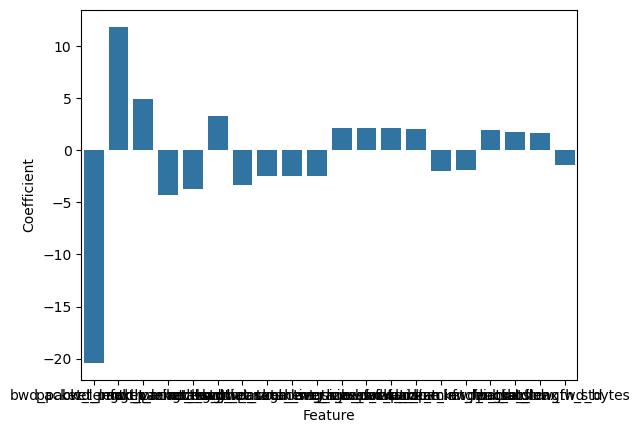

In [52]:
tmp = pd.DataFrame({
    'Feature': X_train.columns.values,
    'Coefficient': log_reg_fit.coef_[0]
})

tmp['abs_val_coef'] = np.abs(tmp['Coefficient'])

tmp2 = tmp.sort_values('abs_val_coef', ascending=False)[:20]

sns.barplot(data=tmp2, x='Feature', y='Coefficient')

## Explore Data

### Destination Port
All destination port (`destination_port`) values occur in the plausible range (0-65,535). For the vast majority of flows, the destination port is 80 (HTTP, 43%), 53 (DNS, 28%), or 443 (HTTPS, 14%). In the training data, all DoS attacks target port 80. However, DoS attacks could target other ports. For generalizability, we will consider excluding `Destination Port` from the model.

In [ ]:
(df_train['destination_port'] < 0).sum()

In [ ]:
(df_train['destination_port'] > 65535).sum()

In [ ]:
df_train['destination_port'].value_counts(normalize=True)

In [ ]:
df_train.groupby('is_attack')['destination_port'].value_counts()

### Flow Duration
Flow duration is provided in microseconds. For interpretability, we convert to seconds. A relatively small number of flows have flow durations less than zero, which is impossible. These flows are dropped. All flows have flow durations <120 seconds, which is consistent with how the CICIDS2017 dataset was generated.

In [ ]:
(df_train['Flow Duration'] / 1_000_000).describe()

In [ ]:
(df_train['Flow Duration'] <= 0).sum()

In [ ]:
df_train = df_train[df_train['Flow Duration'] > 0]

In [ ]:
df_train.groupby('is_attack')['Flow Duration'].describe()

### Total Packets

In [ ]:
df_train[['Total Fwd Packets','Total Backward Packets']].describe()

In [ ]:
df_train.groupby('is_attack')[['Total Fwd Packets','Total Backward Packets']].describe()